# SEGUNDO PROYECTO CURSO DATA SCIENCE - ACAMICA
# Nombre : Sebastián Romero


## Proyecto: Análisis de mercado inmobiliario

¡Bienvenido/a al segundo proyecto de la carrera de Data Science de Acamica! 

El objetivo de este proyecto es reproducir los pasos que haría un/a Data Scientist cuando se enfrenta a una problemática real. Por eso, consta de tres secciones:

A. Transformación de Datos

B. Modelos avanzados

C. Interpretación de modelos

En este proyecto vas a trabajar con un dataset de propiedades en venta publicado en el portal [Properati](www.properati.com.ar).

## A. Transformación de Datos

Lo primero que hacemos es importar las librerias usadas y el dataset, ademas de eliminar las instancias  duplicadas en este.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

pd.set_option('display.width', 150)

In [2]:
datos = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv",sep=',');
datos.drop_duplicates(inplace=True)
datos.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Examinando la información presente en el dataset, ademas del análisis realizado en el proyecto anterior, podemos definir que:

1. La características title y description son de tipo string y contienen la descripción del anuncio, no las utilizaremos para el desarrollo de los modelos.
2. la característica operation_type tiene como único valor Venta y la característica currency tiene como único valor USD. Por lo tanto son redundantes en el dataset y no las necesitamos.
3. las características stard_date, end_date y created_on estan relacionadas con las fechas de anta y baja de la publicación, esta información como ya lo vimos en el proyecto 1 no nos fue util para desarrollar modelos que nos permitieran predecir el precio de las propiedades y por lo tanto las descartaremos.
4. la característica l1 que corresponde al país tiene como único valor Argentina por lo tanto podemos prescindir de esta variable.
5. las características lat y lon que presentan las coordenadas de la ubicación de las propiedades no serán tenidas en cuenta ya que se cuenta con la unicación por barrio y ciudad que desde mi punto de vista es una información mas manejable para el desarrollo de los modelos.
6. Existen instancias para las cuales la superficie cubierta es mayor que la total, esto claramente no es posible y por lo tanto estos valores seran ajustados al valor de la superficie total.

Teniendo esto en cuenta vamos a eliminar dichas caracteristicas del dataset, y revisamos las dimensiones del dataset obtenido

In [3]:
datos.drop(['lat','lon','start_date','end_date','created_on','title','description','currency','operation_type','l1']
           ,axis=1, inplace=True)

datos["surface_covered"] = np.where(datos["surface_covered"] > datos["surface_total"], 
                                    datos["surface_total"], datos["surface_covered"])

print('las dimensiones del dataset son')
print(datos.shape)

las dimensiones del dataset son
(144302, 9)


### Manejo de Outliers

Lo primero que haremos será la eliminación de outliers, para ello observaremos los estadísticos de las variables y graficaremos los diagramas de cajas y bigotes de cada variable númerica

In [4]:
datos.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,144302.000000,144302.000000,138378.000000,124041.000000,122963.000000,1.443020e+05
mean,3.083540,1.984997,1.599178,218.823413,104.925230,2.406946e+05
std,1.420667,1.154110,0.889403,2054.620674,737.881986,3.171541e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,2.000000,1.000000,1.000000,52.000000,47.000000,1.100000e+05
50%,3.000000,2.000000,1.000000,79.000000,68.000000,1.650000e+05
75%,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


se observa que hay valores mínimos y máximos en cada variable muy alejados de los cuartiles que definen la distribución central de los datos. Este es un indicio de la existencia de valores extremos o outliers. Para realizar las gráficas de cajas y bigotes se utilizarán valores de tope para cada variable ya que de lo contrario la grafica se compactaria por los outlieres hasta parecer invisible, es claro que todos estos dato deben ser eliminados.

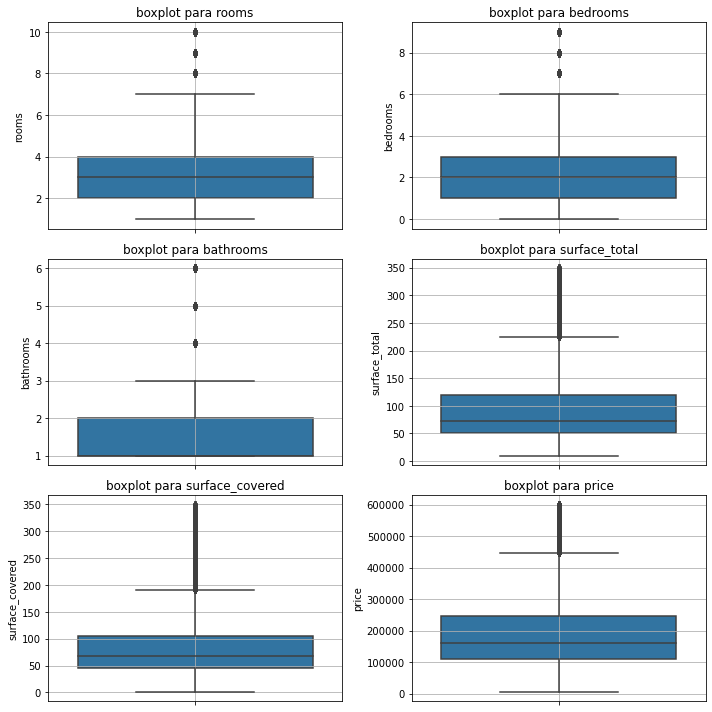

In [5]:
plt.figure(figsize=(10,10))
max_val = [11, 10, 7, 350, 350, 600000]
for i , feature in enumerate(['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']):
    plt.subplot(3,2,i+1)
    sns.boxplot(y = datos[feature][datos[feature] < max_val[i]])
    plt.title(f"boxplot para {feature}")
    plt.ylabel(f"{feature}")
    plt.grid()
    plt.tight_layout()

Vamos a utilizar el método para eliminar outliers del rango intercuartílico, para ellos determinaremos los cuartiles 1 y 3 y el rango intercuartílico

In [6]:
Q1 = datos.quantile(0.25)
Q3 = datos.quantile(0.75)
IQR = Q3 - Q1

In [7]:
datos = datos[~((datos < (Q1 - 1.5*IQR)) | (datos > (Q3 + 1.5*IQR))).any(axis=1)]

In [8]:
datos = datos.reset_index(drop = True)
datos.shape

(120788, 9)

In [9]:
datos.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
1,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
3,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH
4,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH


### Imputación de valores faltantes

Ahora vamos a realizar la imputación de valores faltantes, pero para esto primero debemos entender que tipo de variables son estas y como se relacionan con el dataset

In [10]:
print('tabla de valores faltantes por caracteristica\n')
print(datos.isna().sum())

tabla de valores faltantes por caracteristica

l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4864
surface_total      18429
surface_covered    18814
price                  0
property_type          0
dtype: int64


vemos que existen 3 características (bathrooms, surface_total y surface_covered) que presentan valores faltantes. Del proyecto anterior vimos que las 3 son variables predictoras importantes para el precio y por lo tanto eliminarlas del dataset no es una opción. Una opción podría ser eliminar las instancias con valores faltantes pero esto significaría perder mas de 20mil filas de información en el dataset. Esta fue la manera como lo trabajé en el primer proyecto pero no sería adecuado perder la información así.

Lo siguiente será evaluar como se distribuyen estos valores faltantes en la información. sabemos que las variables categóricas son l2, l3 y property_type

In [11]:
for i , feature in enumerate(['bathrooms','surface_total','surface_covered']):
    datos_1 = datos[feature].isna().groupby(datos.property_type).sum()
    datos_2 = datos[feature].groupby(datos.property_type).size()
    datos_3 = (100*datos_1/datos_2)
    if i == 0:
        porcentaje_na_propiedades = datos_3
    else:
        porcentaje_na_propiedades = pd.merge(porcentaje_na_propiedades, datos_3, on='property_type', how='outer')
        
porcentaje_propiedades = 100*datos["property_type"].value_counts(normalize=True)

print('Distribución de las instancias por tipo de propiedad en porcentaje\n')
print(porcentaje_propiedades)
print('\nPorcentaje de valores faltantes para cada tipo de propiedad\n')
print(porcentaje_na_propiedades)

Distribución de las instancias por tipo de propiedad en porcentaje

Departamento       79.424281
PH                 10.557340
Casa                8.328642
Oficina             0.490115
Lote                0.480180
Cochera             0.214425
Local comercial     0.206146
Otro                0.136603
Depósito            0.120045
Casa de campo       0.042223
Name: property_type, dtype: float64

Porcentaje de valores faltantes para cada tipo de propiedad

                 bathrooms  surface_total  surface_covered
property_type                                             
Casa              9.731610      40.506958        40.059642
Casa de campo    27.450980      98.039216        98.039216
Cochera          96.525097      99.227799        99.227799
Departamento      2.701829      13.282952        13.571689
Depósito         80.689655      98.620690        98.620690
Local comercial  46.987952      93.574297        93.975904
Lote             78.275862      79.655172        98.275862
Oficina      

Vemos que los 3 principales tipos de propiedades (Departamento, PH y Casa) conforman el 98.3% del dataset. Tambien podemos observar que en los demas tipos de propiedades el porcentaje de valores faltantes para estas variables es muy alto, por lo que asumir un valor para imputar en estos tipos de propiedad con la poca información de la que se dispone va a sesgar el dataset.
Debido al poco peso que aportar los demas tipos de propiedades y la incertidumbre frente a la imputación de estas variables para luego generar un modelo que permita predecir precios de manera adecuada, estos demas tipos de propiedad será suprimidos del dataset y nos quedaremos con los 3 principales tipos (Departamento, PH y Casa)

In [12]:
datos = datos[(datos.property_type==porcentaje_propiedades.index[0]) | 
              (datos.property_type==porcentaje_propiedades.index[1]) |
              (datos.property_type==porcentaje_propiedades.index[2])]
datos = datos.reset_index(drop = True)
datos.shape

(118747, 9)

Ahora indagaremos como es la distribución de los valores faltantes con las ciudades que tenemos en la variable l2

In [13]:
for i , feature in enumerate(['bathrooms','surface_total','surface_covered']):
    datos_1 = datos[feature].isna().groupby(datos.l2).sum()
    datos_2 = datos[feature].isna().groupby(datos.l2).size()
    datos_3 = (100*datos_1/datos_2)
    if i == 0:
        porcentaje_na_l2 = datos_3
    else:
        porcentaje_na_l2 = pd.merge(porcentaje_na_l2, datos_3, on='l2', how='outer')
        
porcentaje_l2 = 100*datos["l2"].value_counts(normalize=True)

print('Distribución de las intancias por ciudad en porcentaje\n')
print(porcentaje_l2)
print('\nPorcentaje de valores faltantes para cada ciudad\n')
print(porcentaje_na_l2)

Distribución de las intancias por ciudad en porcentaje

Capital Federal             66.899374
Bs.As. G.B.A. Zona Norte    14.993221
Bs.As. G.B.A. Zona Sur      10.076044
Bs.As. G.B.A. Zona Oeste     8.031361
Name: l2, dtype: float64

Porcentaje de valores faltantes para cada ciudad

                          bathrooms  surface_total  surface_covered
l2                                                                 
Bs.As. G.B.A. Zona Norte   1.842283       8.464390         8.554257
Bs.As. G.B.A. Zona Oeste   7.098668      32.714690        32.515466
Bs.As. G.B.A. Zona Sur     5.867112      35.386544        35.219390
Capital Federal            2.541509      10.166035        10.518498


Vemos que el dataset está conformado mayoritariamente por instancias pertenecientes a la Capital Federal. Ademas podemos observar que en las zonas Oeste y Sur hay una mayor proporción de valores faltantes, pero contamos con la cantidad de información suficiente para hacer una adecuada imputación.
Utilizaremos la mediana para la imputación de valores faltantes segun su tipo de propiedad y ciudad. Evitaremos usar el promedio debido a que pueden existir valores inusuales (la eliminación de outliers no asegura que en los datos no exista una alta dispersión) a los cuales es muy sensible el cálculo del promedio y pueden sesgar nuestros valores imputados.

Las medianas con las cuales reemplazaremos los valores faltantes segun el tipo de propiedad y ciudad se presentan a continuación

In [14]:
for i , feature in enumerate(['bathrooms','surface_total','surface_covered']):
    datos_1 = datos.groupby(['property_type','l2'])[feature].median()
    if i == 0:
        medians = datos_1
    else:
        medians = pd.merge(medians, datos_1, on=['property_type','l2'], how='outer')
        
print('Valores de la media para cada tipo de variable segun la propiedad y ciudad\n')
print(medians)

Valores de la media para cada tipo de variable segun la propiedad y ciudad

                                        bathrooms  surface_total  surface_covered
property_type l2                                                                 
Casa          Bs.As. G.B.A. Zona Norte        2.0          175.5            119.0
              Bs.As. G.B.A. Zona Oeste        2.0          180.0            110.0
              Bs.As. G.B.A. Zona Sur          2.0          179.0            110.0
              Capital Federal                 2.0          168.0            127.0
Departamento  Bs.As. G.B.A. Zona Norte        1.0           71.0             61.0
              Bs.As. G.B.A. Zona Oeste        1.0           50.0             45.0
              Bs.As. G.B.A. Zona Sur          1.0           58.0             53.0
              Capital Federal                 1.0           62.0             55.0
PH            Bs.As. G.B.A. Zona Norte        1.0          107.0             74.0
              Bs.As. G

Ahora vamos a reemplazar los valores faltantes por los arriba presentados

In [15]:
for feature in ['bathrooms','surface_total','surface_covered']:
    datos[feature].fillna((datos.groupby(['property_type','l2'])[feature]).transform('median'), inplace=True)

print('tabla de valores faltantes por caracteristica\n')
print(datos.isna().sum())

tabla de valores faltantes por caracteristica

l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64


Vemos que hemos imputado todos los valores faltantes y ya no queda ninguno en el dataset

### Encoding 

Lo siguiente será codificar las variables categóricas para llevarlas a una forma que permita alimentarlas a los modelos predictores. En primera instancia vamos a codificar la variable l3 que representa los barrios. Una opción es desarrollar one-hot-encoding para esta variable pero nos generaria 89 columnas nuevas. Lo que desarrollaré sera una categorización ordinal de los barrios segun el precio promedio de sus propiedades y para generalizar mas se tendran intervalos de barrios, desde el 1 para los barrios en promedio mas baratos hasta el 18 para los barrios en promedio mas caros.

In [16]:
tablal3 = pd.pivot_table(datos, values=["price"], index=["l3"], aggfunc=np.mean)
tablal3.sort_values(["price"],ascending=True, inplace = True)
barrios = []
encooded = []
for i ,barrio in enumerate(tablal3.index):
    barrios.append(barrio)
    encooded.append(i+1)
barrios_encooded = [(x//5)+1 for x in encooded]
diccionario = dict(zip(barrios,barrios_encooded))
datos["l3_encooded"] = datos['l3'].map(diccionario).astype(int)

datos.drop(['l3'], axis=1, inplace=True)

Para codificar las variables l2 y property_type, se puede implementar one-hot-encoding ya que juntas aportan solo 7 nuevas columnas al dataset.

In [17]:
datos = pd.get_dummies(datos)

In [18]:
datos.shape

(118747, 14)

### Estandarización

Vamos a realizar ahora la estandarización de las variables utilizando el Z-score de estas. No se estandarizarán las variables one-hot-encoded ni la variable precio, ya que esta es nuestro target.

In [19]:
lista_norm = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','l3_encooded']
datos_norm = datos[lista_norm]

normalizar = StandardScaler(copy=True)

In [20]:
datos_norm = normalizar.fit_transform(datos_norm)
datos_norm = pd.DataFrame(datos_norm)
datos_norm.columns = lista_norm

In [21]:
for feature in lista_norm:
    datos[feature] = datos_norm[feature]

In [22]:
datos.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l3_encooded,l2_Bs.As. G.B.A. Zona Norte,l2_Bs.As. G.B.A. Zona Oeste,l2_Bs.As. G.B.A. Zona Sur,l2_Capital Federal,property_type_Casa,property_type_Departamento,property_type_PH
count,1.187470e+05,1.187470e+05,1.187470e+05,1.187470e+05,1.187470e+05,118747.000000,1.187470e+05,118747.000000,118747.000000,118747.000000,118747.000000,118747.000000,118747.000000,118747.000000
mean,-5.379467e-15,1.172736e-15,3.018827e-14,-8.390373e-16,-8.591731e-16,175456.448281,-1.433518e-14,0.149932,0.080314,0.100760,0.668994,0.084718,0.807894,0.107388
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,92768.318409,1.000004e+00,0.357006,0.271779,0.301013,0.470577,0.278463,0.393958,0.309607
min,-1.681558e+00,-1.903400e+00,-6.438836e-01,-1.558781e+00,-2.128285e+00,6000.000000,-2.107128e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.378908e-01,-8.245876e-01,-6.438836e-01,-6.965576e-01,-7.301522e-01,105100.000000,-9.479849e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.057763e-01,2.542245e-01,-6.438836e-01,-3.732239e-01,-3.488432e-01,150000.000000,4.043486e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2.057763e-01,2.542245e-01,1.059944e+00,3.812215e-01,4.455507e-01,225000.000000,9.839200e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,3.980445e+00,4.569473e+00,2.763771e+00,4.088781e+00,4.163314e+00,497500.000000,1.177111e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Vemos que al normalizar las variables por su Z-score encontramos valores extremos en algunas variables, en los cuales Z-score es inferior a -3 o mayor a 3. Esto indica que el dataset aun despues del preprocesamiento sigue muy disperso. Eliminaremos estos valores del dataset.

In [23]:
datos = datos[~((datos['rooms'] < -3) | (datos['rooms'] > 3))]
datos = datos[~((datos['bedrooms'] < -3) | (datos['bedrooms'] > 3))]
datos = datos[~((datos['bathrooms'] < -3) | (datos['bathrooms'] > 3))]
datos = datos[~((datos['surface_total'] < -3) | (datos['surface_total'] > 3))]
datos = datos[~((datos['surface_covered'] < -3) | (datos['surface_covered'] > 3))]
datos = datos[~((datos['l3_encooded'] < -3) | (datos['l3_encooded'] > 3))]             

In [24]:
datos = datos.reset_index(drop = True)
datos.shape

(114769, 14)

### Evaluación de los modelos del primer proyecto

Lo primero que haremos será tomar los puntajes obtenidos para las métricas, de los modelos ejecutados en el primer proyecto. Recordemos que para el primer proyecto utilizamos para el dataset los 3 principales tipos de propiedad (Departamento, PH y Casa) de la ciudad de Buenos Aires, se eliminaron las instancias con valores faltantes y los valores extremos identificados con la gráfica de cajas  y bigotes.

In [25]:
Comparativo1 = {"Regresión lineal P1" : [75779.457278,51475.613795,0.708793],
               "Arbol de desición P1" : [54599.258287,26785.632605,0.848827],
               "KNN P1" : [56241.598933,30613.915591,0.839596]}
Comparativo1 = pd.DataFrame.from_dict(Comparativo1, orient='index',
                                     columns=["rmse_score","mae_score","r2_score"])

Ahora desarrollaremos cada uno de estos 3 modelos con el dataset obtenido mendiante el preprocesamiento realizado.

In [26]:
X = datos.drop(['price'], axis=1)
y = datos['price']
test_size = 0.3 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#### Regresión lineal

El primer modelo será una regresión lineal.

In [27]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

Utilizaremos validación cruzada de 5 hojas para determinar el score del modelo en 3 métricas (RMSE, MAE y R2) con el conjunto de entrenamiento. Luego determinaremos los valores de las mismas métricas con el conjunto de validación, que se reserva para la validación final.

In [28]:
rmse_cv_m1 = cross_val_score(linear_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m1 = cross_val_score(linear_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m1 = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m1.mean(), rmse_cv_m1.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m1.mean(), mae_cv_m1.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m1.mean(), r2_cv_m1.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 52256.22 (+/- 1044.40)
MAE con k = 5 para el conjunto de entrenamiento: 38074.65 (+/- 573.72)
R2 con k = 5 para el conjunto de entrenamiento: 0.667 (+/- 0.006)


In [29]:
y_train_pred_m1 = linear_model.predict(X_train)
y_test_pred_m1 = linear_model.predict(X_test)

rmse_test_m1 = np.sqrt(mean_squared_error(y_test, y_test_pred_m1))
mae_test_m1 = mean_absolute_error(y_test, y_test_pred_m1)
r2_test_m1 = r2_score(y_test, y_test_pred_m1)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m1))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m1))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m1))

RMSE para el conjunto de validación: 51910.83
MAE para el conjunto de validación: 38050.43
R2 para el conjunto de validación: 0.674


Vamos a graficar la distribución del error para los conjuntos de entrenamiento y validación y la gráfica de dispersión para los precios reales contra los predichos por el modelo.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


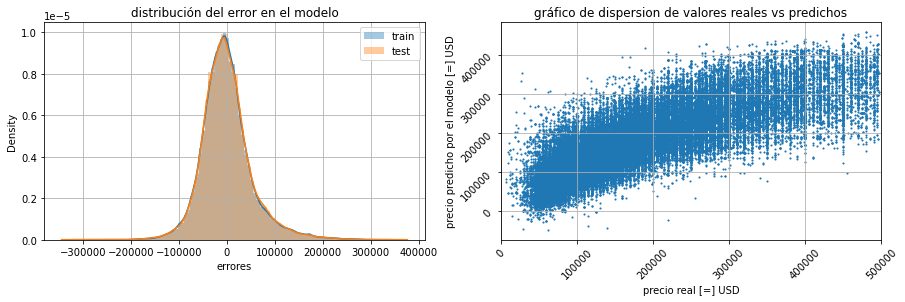

In [30]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m1, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m1, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, linear_model.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

#### Arbol de desición

Para el árbol de desición utilizaremos el método GridSearchCV para la optimización de la profundidad del árbol.

In [31]:
tree_regressor = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), 
                              param_grid = {'max_depth': [i for i in range(1,21)]}, cv = 4, verbose = 0, n_jobs = -1)
tree_regressor.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]})

In [32]:
tree_regressor.best_params_

{'max_depth': 13}

In [33]:
tree_regressor = tree_regressor.best_estimator_

Graficaremos la curva de validación para corroborar de manera visual el hiperparámetro obtenido con el método GridSearchCV.

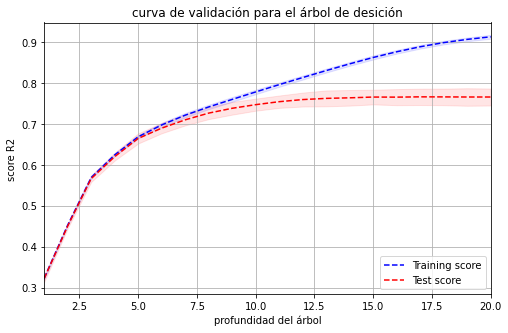

In [34]:
max_value = 20
param_range = [i for i in range(1,max_value+1)]
train_scores, test_scores = validation_curve(tree_regressor, X, y, param_name="max_depth", 
                                             param_range=param_range,scoring="r2",cv=4)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(param_range, train_scores_mean, '--', color="b", label="Training score")
plt.plot(param_range, test_scores_mean, '--', color="r", label="Test score")
plt.title('curva de validación para el árbol de desición')
plt.legend(loc = 4)
plt.ylabel('score R2')
plt.xlabel('profundidad del árbol')
plt.xlim(1,max_value)
plt.grid()
plt.show()

Vemos que para max_depth igual a 13 se obtienen adecuados resultados, en el trade off entre bias y varianza.

A continuación se muestran las caracteristicas mas importantes para el modelo de árbol de desición.
En esta gráfica se observa que el número de baños, superficie total y cubierta y la codificación de los barrios son las variables mas importantes para el desarrollo del modelo.

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


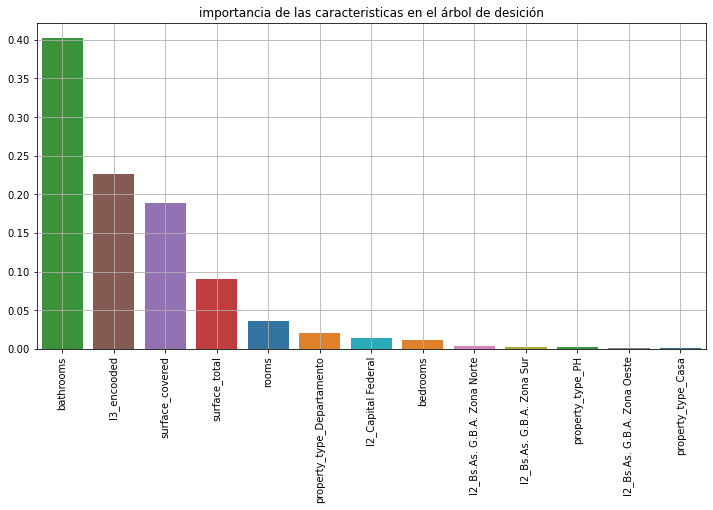

In [35]:
importancia_tree = tree_regressor.feature_importances_
columnas = X.columns
indices_tree = np.argsort(importancia_tree)[::-1]
colors = dict(zip(columnas,sns.color_palette(n_colors=len(columnas))))

plt.figure(figsize = (12,6))
sns.barplot(columnas[indices_tree], importancia_tree[indices_tree], palette=colors)
plt.xticks(rotation = 90)
plt.title('importancia de las caracteristicas en el árbol de desición')
plt.grid()
plt.show()

Evaluaremos las métricas de la misma manera que para el modelo anterior. procederemos de la misma manera con los siguientes modelos.

In [36]:
rmse_cv_m2 = cross_val_score(tree_regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m2 = cross_val_score(tree_regressor, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m2 = cross_val_score(tree_regressor, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m2.mean(), rmse_cv_m2.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m2.mean(), mae_cv_m2.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m2.mean(), r2_cv_m2.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 44511.14 (+/- 669.22)
MAE con k = 5 para el conjunto de entrenamiento: 29554.02 (+/- 357.98)
R2 con k = 5 para el conjunto de entrenamiento: 0.759 (+/- 0.008)


In [37]:
y_train_pred_m2 = tree_regressor.predict(X_train)
y_test_pred_m2 = tree_regressor.predict(X_test)

rmse_test_m2 = np.sqrt(mean_squared_error(y_test, y_test_pred_m2))
mae_test_m2 = mean_absolute_error(y_test, y_test_pred_m2)
r2_test_m2 = r2_score(y_test, y_test_pred_m2)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m2))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m2))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m2))

RMSE para el conjunto de validación: 43341.02
MAE para el conjunto de validación: 28904.76
R2 para el conjunto de validación: 0.773


Graficaremos la distribución del error y la dispersión entre los valores reales y predichos para los precios. Procederemos de la misma manera con los siguiente modelos.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


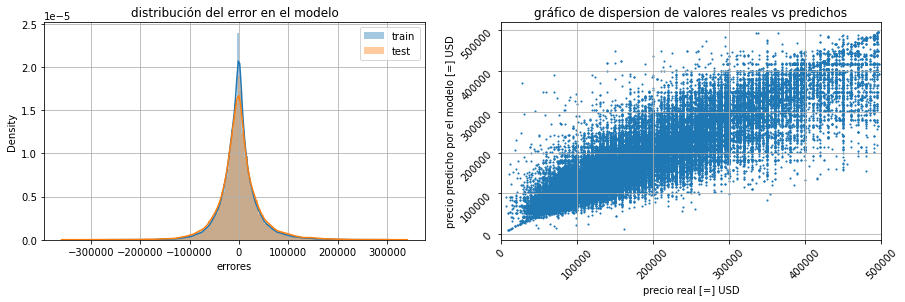

In [38]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m2, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m2, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, tree_regressor.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

#### K vecinos mas cercanos

El siguiente modelo es K vecinos mas cercanos (knn por sus siglas en ingles). Utilizaremos el método GridSearchCV para la optimización del número de vecinos.

In [39]:
knn_regressor = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = {'n_neighbors': [i for i in range(1,11)]}, 
                             cv = 4, verbose = 0, n_jobs = -1)
knn_regressor.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [40]:
knn_regressor.best_params_

{'n_neighbors': 9}

In [41]:
knn_regressor = knn_regressor.best_estimator_

Verificamos el número de vecinos obtenido con el método GridSearchCV, por medio de la curva de validación. En este se observa que para 9 vecinos el modelo tiene un mejor resultado.

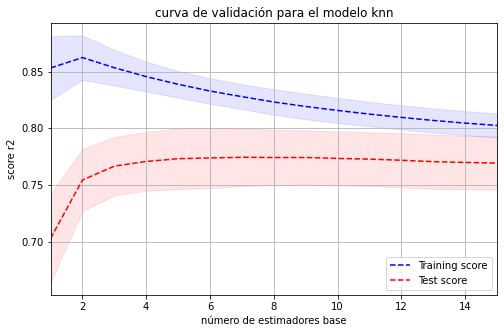

In [42]:
max_value = 15
param_range = [i for i in range(1,max_value+1)]
train_scores, test_scores = validation_curve(knn_regressor, X, y, param_name="n_neighbors", 
                                             param_range=param_range,scoring="r2",cv=3)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(param_range, train_scores_mean, '--', color="b", label="Training score")
plt.plot(param_range, test_scores_mean, '--', color="r", label="Test score")
plt.title('curva de validación para el modelo knn')
plt.legend(loc = 4)
plt.ylabel('score r2')
plt.xlabel('número de estimadores base')
plt.xlim(1,max_value)
plt.grid()
plt.show()

In [43]:
rmse_cv_m3 = cross_val_score(knn_regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m3 = cross_val_score(knn_regressor, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m3 = cross_val_score(knn_regressor, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m3.mean(), rmse_cv_m3.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m3.mean(), mae_cv_m3.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m3.mean(), r2_cv_m3.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 43145.21 (+/- 786.27)
MAE con k = 5 para el conjunto de entrenamiento: 28487.35 (+/- 418.14)
R2 con k = 5 para el conjunto de entrenamiento: 0.773 (+/- 0.007)


In [44]:
y_train_pred_m3 = knn_regressor.predict(X_train)
y_test_pred_m3 = knn_regressor.predict(X_test)

rmse_test_m3 = np.sqrt(mean_squared_error(y_test, y_test_pred_m3))
mae_test_m3 = mean_absolute_error(y_test, y_test_pred_m3)
r2_test_m3 = r2_score(y_test, y_test_pred_m3)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m3))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m3))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m3))

RMSE para el conjunto de validación: 42042.33
MAE para el conjunto de validación: 27655.29
R2 para el conjunto de validación: 0.786


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


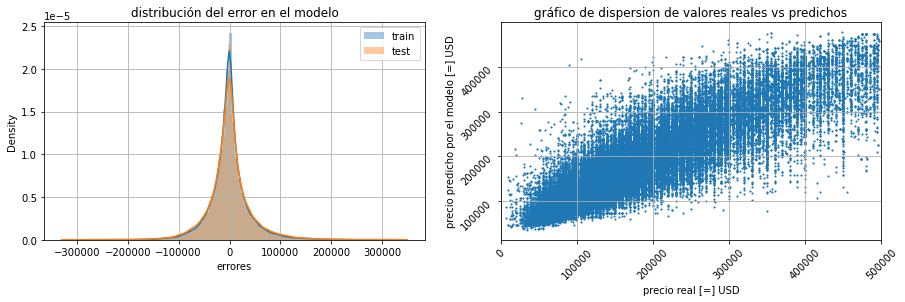

In [45]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m3, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m3, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, knn_regressor.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

### Comparativo de los modelos básicos del proyecto #2 con los del proyecto #1

In [46]:
rmse_cv_m1 = -rmse_cv_m1.mean()
rmse_cv_m2 = -rmse_cv_m2.mean()
rmse_cv_m3 = -rmse_cv_m3.mean()

mae_cv_m1 = -mae_cv_m1.mean()
mae_cv_m2 = -mae_cv_m2.mean()
mae_cv_m3 = -mae_cv_m3.mean()

r2_cv_m1 = r2_cv_m1.mean()
r2_cv_m2 = r2_cv_m2.mean()
r2_cv_m3 = r2_cv_m3.mean()

Comparativo2 = {"Regresión lineal" : [rmse_cv_m1,rmse_test_m1,mae_cv_m1,mae_test_m1,r2_cv_m1,r2_test_m1],
               "Arbol de desición" : [rmse_cv_m2,rmse_test_m2,mae_cv_m2,mae_test_m2,r2_cv_m2,r2_test_m2],
               "K vecinos mas cercanos" : [rmse_cv_m3,rmse_test_m3,mae_cv_m3,mae_test_m3,r2_cv_m3,r2_test_m3]}
Comparativo2 = pd.DataFrame.from_dict(Comparativo2, orient='index',
                                      columns=["rmse_cv_score","rmse_test_score","mae_cv_score","mae_test_score",
                                               "r2_cv_score","r2_test_score"])

In [47]:
Comparativo1

,rmse_score,mae_score,r2_score
Regresión lineal P1,75779.457278,51475.613795,0.708793
Arbol de desición P1,54599.258287,26785.632605,0.848827
KNN P1,56241.598933,30613.915591,0.839596


In [48]:
Comparativo2

,rmse_cv_score,rmse_test_score,mae_cv_score,mae_test_score,r2_cv_score,r2_test_score
Regresión lineal,52256.215365,51910.833264,38074.648105,38050.431007,0.667345,0.674377
Arbol de desición,44511.140637,43341.024032,29554.022990,28904.757693,0.758614,0.773015
K vecinos mas cercanos,43145.214193,42042.330398,28487.351215,27655.288516,0.773208,0.786414


Vemos que las métricas seleccionadas son mejores para los modelos desarrollados en el proyecto 1, en el cual consideramos solo las propiedades de tipo Departamento, PH y casa de la capital federal. En dicho  proyecto se eliminaron los outliers por medio de una inspección visual de las gráficas de cajas y bigotes para cada variable (un procedimiento que no fue exhaustivo) y las instancias con valores faltantes fueron eliminadas.
A mi parecer la disminución en el desempeño se basa en que al utilizar las propiedades de la 4 ciudades hay mayor dispersión en los datos.

## B. Modelos Avanzados

Vamos a desarrollar los siguiente modelos avanzados
1. Regresión polinómica
2. Ensamble tipo Bagging con arbol de desición como estimador base
2. Ensamble tipo Boosting con arbol de desición como estimador base

In [49]:
X = datos.drop(['price'], axis=1)
y = datos['price']
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)

### Regresión polinómica

Para el desarrollo de la regresión polinómica utilizamos un Pipeline donde agrupamos el método que genera las caracteristicas polinómicas y la regresión lineal. Con esto se hace una curva de validación para verificar el score segun el grado del polinomio. Al intentar correr el grado del polinomio con valores de 5 o superiores las caracteristicas técnicas de mi computadora son sobrepasadas y el codigo no puede compilar por falta de memoria, es por eso que trabajo con este hiperparámetro hasta 4. Por la misma razón no tiene sentido usar regularización, ya que esta tiene efecto para los grados altos de polinomios.

In [50]:
steps = [('poly', PolynomialFeatures()), ('linearmodel',LinearRegression())]
polynomial_model = Pipeline(steps)

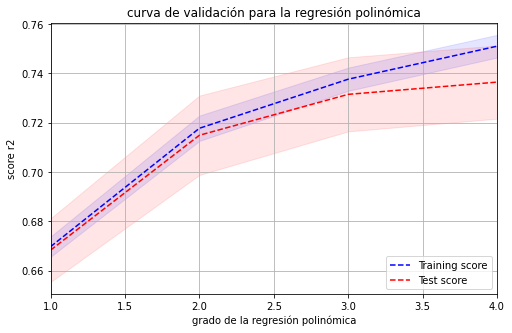

In [51]:
max_grade = 4
param_range = np.arange(1,max_grade+1)
train_scores, test_scores = validation_curve(polynomial_model, X, y, param_name="poly__degree", 
                                             param_range=param_range,scoring="r2",cv=4)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(param_range, train_scores_mean, '--', color="b", label="Training score")
plt.plot(param_range, test_scores_mean, '--', color="r", label="Test score")
plt.title('curva de validación para la regresión polinómica')
plt.legend(loc = 4)
plt.ylabel('score r2')
plt.xlabel('grado de la regresión polinómica')
plt.xlim(1,max_grade)
plt.grid()
plt.show()

In [52]:
steps = [('poly', PolynomialFeatures(4)), ('linearmodel',LinearRegression())]
polynomial_model = Pipeline(steps)
polynomial_model.fit(X_train,y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('linearmodel', LinearRegression())])

In [53]:
rmse_cv_m4 = cross_val_score(polynomial_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m4 = cross_val_score(polynomial_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m4 = cross_val_score(polynomial_model, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m4.mean(), rmse_cv_m4.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m4.mean(), mae_cv_m4.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m4.mean(), r2_cv_m4.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 46550.96 (+/- 895.95)
MAE con k = 5 para el conjunto de entrenamiento: 32793.96 (+/- 472.95)
R2 con k = 5 para el conjunto de entrenamiento: 0.736 (+/- 0.008)


In [54]:
y_train_pred_m4 = polynomial_model.predict(X_train)
y_test_pred_m4 = polynomial_model.predict(X_test)

rmse_test_m4 = np.sqrt(mean_squared_error(y_test, y_test_pred_m4))
mae_test_m4 = mean_absolute_error(y_test, y_test_pred_m4)
r2_test_m4 = r2_score(y_test, y_test_pred_m4)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m4))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m4))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m4))

RMSE para el conjunto de validación: 45830.08
MAE para el conjunto de validación: 32429.91
R2 para el conjunto de validación: 0.746


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


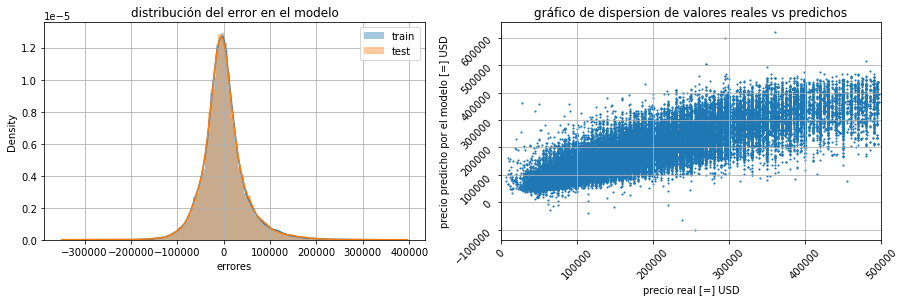

In [55]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m4, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m4, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, polynomial_model.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

### Ensamble tipo Bagging con árbol de desición como estimador base

Para el desarrollo de este modelo se utiliza como estimador base el árbol de desición y se lleva al overfitting, ya que la idea del modelo es generar un conjunto de estimadores base con alta varianza y bajo sesgo, y por medio de un desarrollo en paralelo obtener un modelo que tome en cuenta los resultados de todos y tenga baja varianza y bajo sesgo.
Inicialmente se utilizara un modelo de bagging que solo usa bootstrap para las instancias.

In [56]:
base_estimator = DecisionTreeRegressor(max_depth = None, random_state=42)
Bagging_model = BaggingRegressor(base_estimator, bootstrap = True, bootstrap_features = False, n_estimators = 100,
                                 oob_score = False, n_jobs = -1)

Utilizaremos una curva de validación para determinar el número de estimadores adecuado para el modelo. De esta nos queda claro que a partir de 60 estimadores base el modelo tiene un rendimiento adecuado.

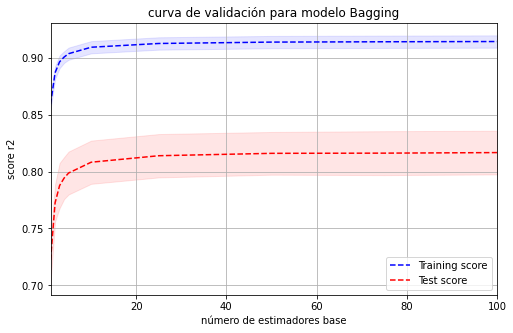

In [57]:
param_range = [1,2,3,4,5,10,25,50,75,100]
train_scores, test_scores = validation_curve(Bagging_model, X, y, param_name="n_estimators", 
                                             param_range=param_range,scoring="r2",cv=4)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(param_range, train_scores_mean, '--', color="b", label="Training score")
plt.plot(param_range, test_scores_mean, '--', color="r", label="Test score")
plt.title('curva de validación para modelo Bagging')
plt.legend(loc = 4)
plt.ylabel('score r2')
plt.xlabel('número de estimadores base')
plt.xlim(1,100)
plt.grid()
plt.show()

Instanciamos nuevamente el modelo con el número de estimadores base definido.

In [58]:
Bagging_model = BaggingRegressor(base_estimator, bootstrap = True, bootstrap_features = False, n_estimators = 60,
                                 oob_score = True, n_jobs = -1)
Bagging_model.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                 n_estimators=60, n_jobs=-1, oob_score=True)

In [59]:
rmse_cv_m5 = cross_val_score(Bagging_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m5 = cross_val_score(Bagging_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m5 = cross_val_score(Bagging_model, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m5.mean(), rmse_cv_m5.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m5.mean(), mae_cv_m5.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m5.mean(), r2_cv_m5.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 39445.72 (+/- 382.68)
MAE con k = 5 para el conjunto de entrenamiento: 24604.58 (+/- 155.17)
R2 con k = 5 para el conjunto de entrenamiento: 0.811 (+/- 0.006)


In [60]:
y_train_pred_m5 = Bagging_model.predict(X_train)
y_test_pred_m5 = Bagging_model.predict(X_test)

rmse_test_m5 = np.sqrt(mean_squared_error(y_test, y_test_pred_m5))
mae_test_m5 = mean_absolute_error(y_test, y_test_pred_m5)
r2_test_m5 = r2_score(y_test, y_test_pred_m5)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m5))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m5))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m5))

RMSE para el conjunto de validación: 38055.39
MAE para el conjunto de validación: 23611.25
R2 para el conjunto de validación: 0.825


Los ensambles de tipo bagging, dado que realizan bootstrap de las muestras, cuentan con subconjuntos de muestras que no son usadas para el entrenamiento dentro de los conjuntos de entrenamiento. Para estos subconjuntos se puede determinar el score como si se tratara de un conjunto de validación. Este se presenta a continuación.

In [61]:
r2_oob_m5 = Bagging_model.oob_score_
print('R2 para el conjunto OOB : %0.3f' % (r2_oob_m5))

R2 para el conjunto OOB : 0.816


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


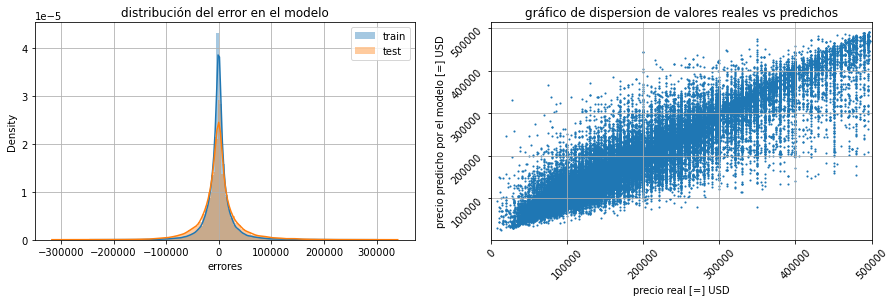

In [62]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m5, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m5, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, Bagging_model.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

### Ensamble Random Forest

El modelo de Random Forest realiza boostrap tanto de las instancias como de las caracteristicas, ademas usa árboles de desición como estimadores base. Por lo tanto este es un caso particular de los ensambles tipo Bagging. 

In [63]:
RandomForest_model = RandomForestRegressor(n_estimators=100, max_features="log2", n_jobs=-1, oob_score = False,
                                           max_depth = None, random_state = 42)

Utilizaremos una curva de validación para determinar el número de estimadores adecuado para el modelo. De esta nos queda claro que a partir de 60 estimadores base el modelo tiene un rendimiento adecuado.

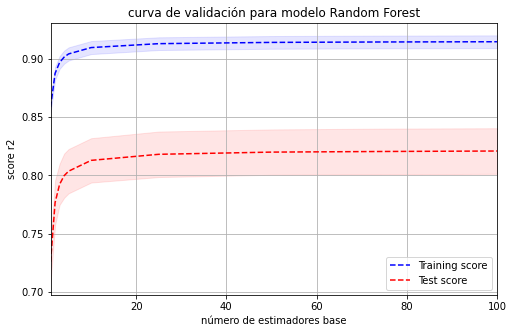

In [64]:
param_range = [1,2,3,4,5,10,25,50,75,100]
train_scores, test_scores = validation_curve(RandomForest_model, X, y, param_name="n_estimators", 
                                             param_range=param_range,scoring="r2",cv=4)
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(param_range, train_scores_mean, '--', color="b", label="Training score")
plt.plot(param_range, test_scores_mean, '--', color="r", label="Test score")
plt.title('curva de validación para modelo Random Forest')
plt.legend(loc = 4)
plt.ylabel('score r2')
plt.xlabel('número de estimadores base')
plt.xlim(1,100)
plt.grid()
plt.show()

Instanciamos nuevamente el modelo con el número de estimadores base definido.

In [65]:
RandomForest_model = RandomForestRegressor(n_estimators=60, max_features="log2", n_jobs=-1, oob_score = True,
                                           max_depth = None, random_state = 42)

In [66]:
RandomForest_model.fit(X_train,y_train)

RandomForestRegressor(max_features='log2', n_estimators=60, n_jobs=-1,
                      oob_score=True, random_state=42)

In [67]:
rmse_cv_m6 = cross_val_score(RandomForest_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m6 = cross_val_score(RandomForest_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m6 = cross_val_score(RandomForest_model, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m6.mean(), rmse_cv_m6.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m6.mean(), mae_cv_m6.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m6.mean(), r2_cv_m6.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 38985.49 (+/- 428.32)
MAE con k = 5 para el conjunto de entrenamiento: 24321.58 (+/- 193.52)
R2 con k = 5 para el conjunto de entrenamiento: 0.815 (+/- 0.007)


In [68]:
y_train_pred_m6 = RandomForest_model.predict(X_train)
y_test_pred_m6 = RandomForest_model.predict(X_test)

rmse_test_m6 = np.sqrt(mean_squared_error(y_test, y_test_pred_m6))
mae_test_m6 = mean_absolute_error(y_test, y_test_pred_m6)
r2_test_m6 = r2_score(y_test, y_test_pred_m6)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m6))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m6))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m6))

RMSE para el conjunto de validación: 37694.86
MAE para el conjunto de validación: 23399.38
R2 para el conjunto de validación: 0.828


Al igual que para el modelo anterior, al tratarse de un caso específico de bagging, tiene un conjunto de muestras OOB a partir del cual podemos calcular su score, como si se tratara de un score de validación

In [69]:
r2_oob_m6 = RandomForest_model.oob_score_
print('R2 para el conjunto OOB : %0.3f' % (r2_oob_m6))

R2 para el conjunto OOB : 0.821


Random Forest al tratarse de un modelo que utiliza exclusivamente árboles como estimador base, permite determinar las caracteristicas mas importantes para el desarrollo de los modelos. A continuación se presenta la importancia de las caracteristicas para este modelo.

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


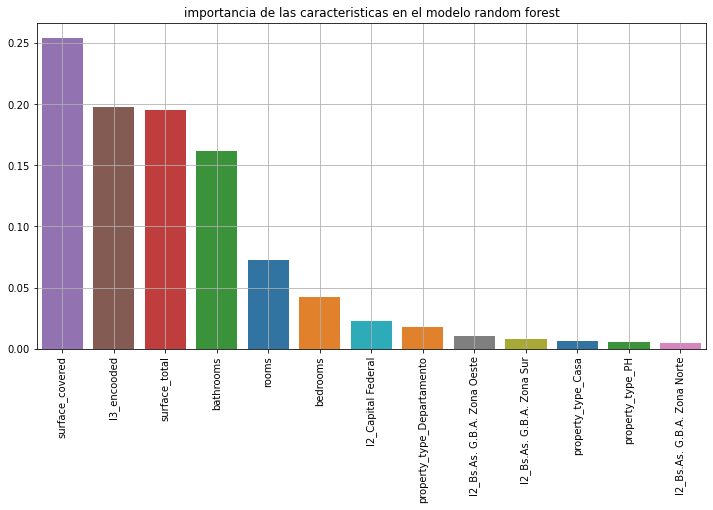

In [70]:
importancia_forest = RandomForest_model.feature_importances_
columnas = X.columns
indices_forest = np.argsort(importancia_forest)[::-1]

plt.figure(figsize = (12,6))
sns.barplot(columnas[indices_forest], importancia_forest[indices_forest], palette=colors)
plt.xticks(rotation = 90)
plt.title('importancia de las caracteristicas en el modelo random forest')
plt.grid()
plt.show()

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


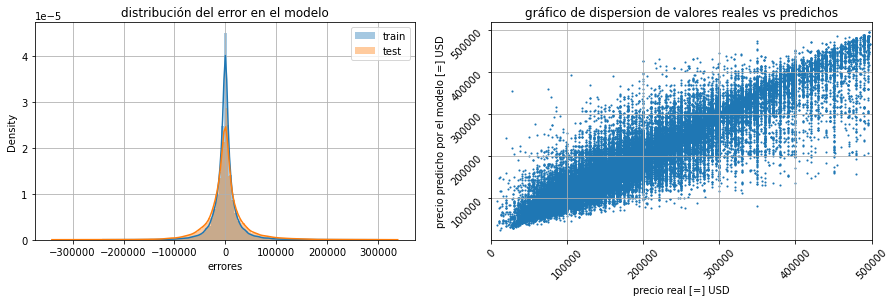

In [71]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m6, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m6, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, RandomForest_model.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

### Ensamble tipo Boosting con árbol de desición como estimador base

Para el desarrollo de este modelo se utiliza como estimador base el árbol de desición y se utilizan subajustados (profundidad máxima igual a 3), ya que la idea del modelo es generar un conjunto de estimadores base con baja varianza y alto sesgo, y por medio de un desarrollo en serie que aprende de los errores de los estimadores previos, obtener un modelo que tenga baja varianza y bajo sesgo.
Este modelo presenta un trade off entre la taza de aprendizaje y el número de estimadores, por lo tanto se desarrollará una optimización con el método GridSearchCV para determinar estos hiperparámetros.

In [72]:
base_estimator = DecisionTreeRegressor(max_depth = 3, random_state=42)
estimator = AdaBoostRegressor(base_estimator, random_state=42)

AdaBoost_model = GridSearchCV(estimator, cv = 4, verbose = 0, n_jobs = -1,
                              param_grid = {'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34, 36],
                                            'learning_rate': [0.1, 0.12, 0.14, 0.16, 0.18, 2]})
AdaBoost_model.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                                              random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.12, 0.14, 0.16, 0.18, 2],
                         'n_estimators': [20, 22, 24, 26, 28, 30, 32, 34, 36]})

In [73]:
AdaBoost_model.best_params_

{'learning_rate': 0.16, 'n_estimators': 24}

Obtenemos como valores óptimos para el modelo AdaBoost 24 estimadores base y una tasa de aprendizaje de 0.16. Utilizamos estos datos para el modelo Adaboost

In [74]:
AdaBoost_model = AdaBoost_model.best_estimator_

In [75]:
AdaBoost_model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                       random_state=42),
                  learning_rate=0.16, n_estimators=24, random_state=42)

In [76]:
rmse_cv_m7 = cross_val_score(AdaBoost_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
mae_cv_m7 = cross_val_score(AdaBoost_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
r2_cv_m7 = cross_val_score(AdaBoost_model, X_train, y_train, scoring='r2', cv=5)

print('RMSE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-rmse_cv_m7.mean(), rmse_cv_m7.std() * 2))
print('MAE con k = 5 para el conjunto de entrenamiento: %0.2f (+/- %0.2f)' % (-mae_cv_m7.mean(), mae_cv_m7.std() * 2))
print('R2 con k = 5 para el conjunto de entrenamiento: %0.3f (+/- %0.3f)' % (r2_cv_m7.mean(), r2_cv_m7.std() * 2))

RMSE con k = 5 para el conjunto de entrenamiento: 55290.35 (+/- 1347.61)
MAE con k = 5 para el conjunto de entrenamiento: 41437.22 (+/- 928.46)
R2 con k = 5 para el conjunto de entrenamiento: 0.628 (+/- 0.010)


In [77]:
y_train_pred_m7 = AdaBoost_model.predict(X_train)
y_test_pred_m7 = AdaBoost_model.predict(X_test)

rmse_test_m7 = np.sqrt(mean_squared_error(y_test, y_test_pred_m7))
mae_test_m7 = mean_absolute_error(y_test, y_test_pred_m7)
r2_test_m7 = r2_score(y_test, y_test_pred_m7)

print('RMSE para el conjunto de validación: %0.2f' % (rmse_test_m7))
print('MAE para el conjunto de validación: %0.2f' % (mae_test_m7))
print('R2 para el conjunto de validación: %0.3f' % (r2_test_m7))

RMSE para el conjunto de validación: 55044.71
MAE para el conjunto de validación: 41569.57
R2 para el conjunto de validación: 0.634


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


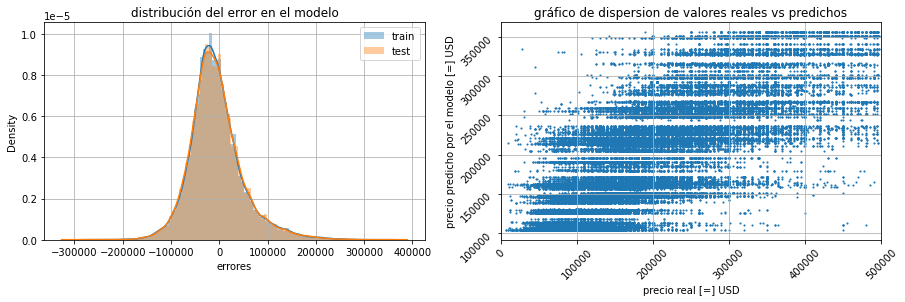

In [78]:
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_m7, bins = 100, label = 'train')
sns.distplot(y_test - y_test_pred_m7, bins = 100, label = 'test')
plt.title("distribución del error en el modelo")
plt.xlabel('errores')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.scatter(y, AdaBoost_model.predict(X), s = 1.2)
plt.title("gráfico de dispersion de valores reales vs predichos")
plt.xlabel('precio real [=] USD')
plt.ylabel('precio predicho por el modelo [=] USD')
plt.xlim(0,500000)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.grid()
plt.show()

### Comparativo de los modelos obtenidos

Una vez desarrollados todos los modelos vamos a comparar los resultados de las métricas para determinar cual es el modelo que mejor predice los precios de las propiedades 

In [79]:
rmse_cv_m4 = -rmse_cv_m4.mean()
rmse_cv_m5 = -rmse_cv_m5.mean()
rmse_cv_m6 = -rmse_cv_m6.mean()
rmse_cv_m7 = -rmse_cv_m7.mean()

mae_cv_m4 = -mae_cv_m4.mean()
mae_cv_m5 = -mae_cv_m5.mean()
mae_cv_m6 = -mae_cv_m6.mean()
mae_cv_m7 = -mae_cv_m7.mean()

r2_cv_m4 = r2_cv_m4.mean()
r2_cv_m5 = r2_cv_m5.mean()
r2_cv_m6 = r2_cv_m6.mean()
r2_cv_m7 = r2_cv_m7.mean()

Comparativo3 = {"Regresión polinómica" : [rmse_cv_m4,rmse_test_m4,mae_cv_m4,mae_test_m4,r2_cv_m4,r2_test_m4],
                "Ensamble tipo Bagging" : [rmse_cv_m5,rmse_test_m5,mae_cv_m5,mae_test_m5,r2_cv_m5,r2_test_m5],
                "Ensamble Random Forest" : [rmse_cv_m6,rmse_test_m6,mae_cv_m6,mae_test_m6,r2_cv_m6,r2_test_m6],
                "Ensamble tipo Boosting" : [rmse_cv_m7,rmse_test_m7,mae_cv_m7,mae_test_m7,r2_cv_m7,r2_test_m7]}
Comparativo3 = pd.DataFrame.from_dict(Comparativo3, orient='index',
                                     columns=["rmse_cv_score","rmse_test_score","mae_cv_score","mae_test_score",
                                              "r2_cv_score","r2_test_score"])

In [80]:
Comparativo = pd.concat([Comparativo2,Comparativo3])
Comparativo

,rmse_cv_score,rmse_test_score,mae_cv_score,mae_test_score,r2_cv_score,r2_test_score
Regresión lineal,52256.215365,51910.833264,38074.648105,38050.431007,0.667345,0.674377
Arbol de desición,44511.140637,43341.024032,29554.022990,28904.757693,0.758614,0.773015
K vecinos mas cercanos,43145.214193,42042.330398,28487.351215,27655.288516,0.773208,0.786414
Regresión polinómica,46550.964366,45830.081738,32793.955267,32429.914321,0.736001,0.746195
Ensamble tipo Bagging,39445.717230,38055.389320,24604.577075,23611.246102,0.810705,0.825003
Ensamble Random Forest,38985.485688,37694.864853,24321.577245,23399.377625,0.814815,0.828303
Ensamble tipo Boosting,55290.349606,55044.712063,41437.218851,41569.569297,0.627593,0.633874


Se observa que los mejores resultados para las métricas (RMSE y MAE mínimos y R2 máximo) se dan para el modelo Random Forest, razón por la cual se elige dicho modelo como el mas adecuado.

Es importante tener en cuenta el costo computacional que generan algunos modelos, el caso de los modelos K vecinos mas cercanos y regresión polinómica (este último no me permitió desarrollar un ajuste polinomico de orden mayor a 4) tuvieron un tiempo de computo muy prologado y un consumo muy alto de recursos. Por lo tanto al tener un rendimiento muy similar en sus métricas los modelos knn y árbol de desición, por ejemplo, elegiría claramente a un modelo que me permite computar mucho mas rápido con una perdida de 2% en score aproximadamente.

## C. Interpretación de modelos

A partir de los modelos desarrollados se dara respuesta a algunas preguntas

#### ¿Qué variables fueron relevantes para el modelo para hacer una predicción?

Podemos observar para los modelos Árbol de desición y Random Forest, la importancia que tuvo cada caracteristica en la siguiente tabla. Posteriomente una gráfica de barras para cada modelo donde se presenta la importancia de las caracteristicas en orden descendente.

In [81]:
print('Importancia de las caracteristicas para cada modelo [%]\n')
print(pd.DataFrame({'Árbol de desición':importancia_tree*100, 'Random Forest':importancia_forest*100}, index = columnas))

Importancia de las caracteristicas para cada modelo [%]

                             Árbol de desición  Random Forest
rooms                                 3.597738       7.228682
bedrooms                              1.143754       4.224798
bathrooms                            40.196886      16.199491
surface_total                         9.021372      19.509260
surface_covered                      18.821254      25.372861
l3_encooded                          22.695212      19.786821
l2_Bs.As. G.B.A. Zona Norte           0.334132       0.516573
l2_Bs.As. G.B.A. Zona Oeste           0.132167       1.058764
l2_Bs.As. G.B.A. Zona Sur             0.262198       0.825906
l2_Capital Federal                    1.390203       2.274525
property_type_Casa                    0.120516       0.608572
property_type_Departamento            2.022652       1.809388
property_type_PH                      0.261917       0.584357


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


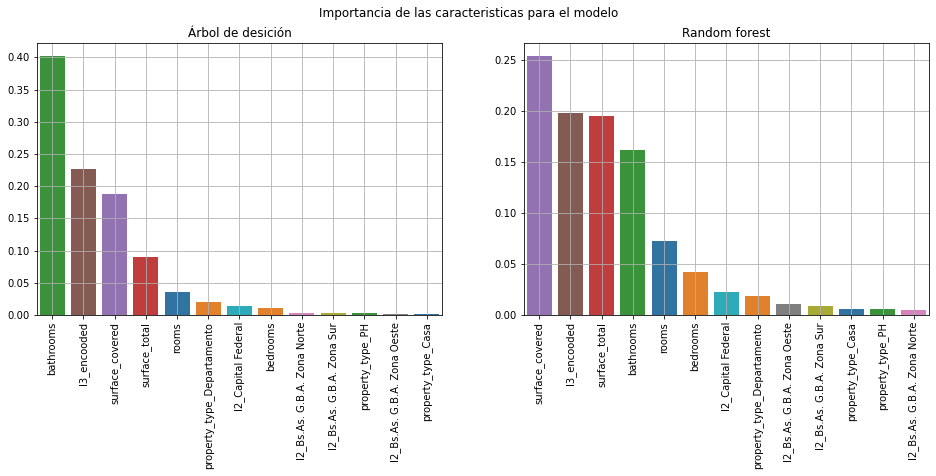

In [82]:
plt.figure(figsize = (16,5))
plt.suptitle('Importancia de las caracteristicas para el modelo')

plt.subplot(1,2,1)
sns.barplot(columnas[indices_tree], importancia_tree[indices_tree], palette=colors)
plt.xticks(rotation = 90)
plt.title('Árbol de desición')
plt.grid()

plt.subplot(1,2,2)
sns.barplot(columnas[indices_forest], importancia_forest[indices_forest], palette=colors)
plt.xticks(rotation = 90)
plt.title('Random forest')
plt.grid()

plt.show()

En el modelo arbol de desición la variable mas importante con mucha diferencia es bathrooms, seguido de l3_encooded, surface_covered y surface_total, mientras que en el modelo Random Forest, que tuvo el mejor desempeño entre todos los modelos, la variable mas importante fue surface_covered, seguido de l3_encooded, surface_total y bathrooms.

La principal caracteristica del modelo Random Forest es que cada uno de los árboles utilizados como estimadores base, tienen acceso a solo una porción de la cantidad total de instancias y de caracteristicas, por lo existe mucha variabilidad entre los diferentes árboles. Esto hace que cada árbol tome diferentes desiciones con el fin de disminuir el error en sus ramas y pueda considerar utilizar caracteristicas aparentemente menos importantes cuando estan presentes junto con las caracteristicas mas importantes arriba mencionadas

Por lo tanto se observa una disminución en la importancia de las caracteristicas mas importantes, pero tambien un aumento en la importancia de aquellas caracteristicas que aparentemente no tenian peso en el modelo individual, como es el caso de varias variables dummies que surgen de las ciudades y los tipos de propiedad.

Ahora veremos la importancia de las caracteristicas para algunos estimadores base aleatorios que hacen parte del modelo Random Forest

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\l

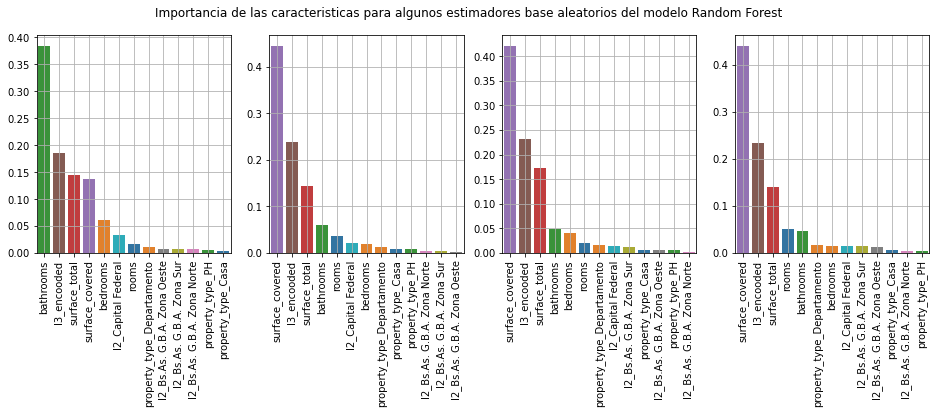

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\l

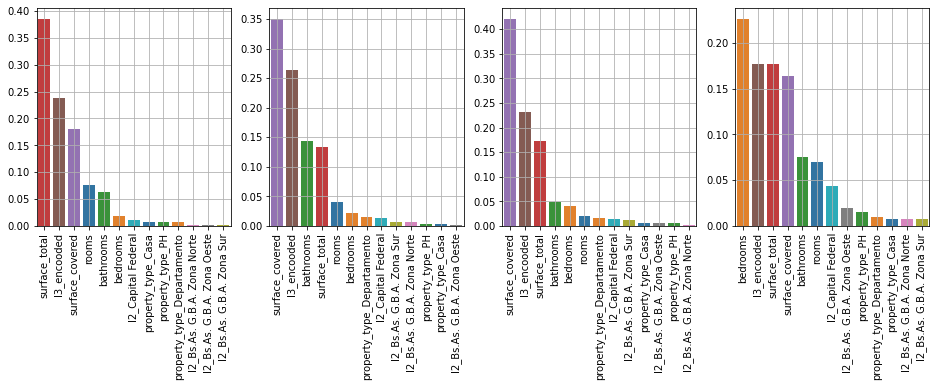

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\l

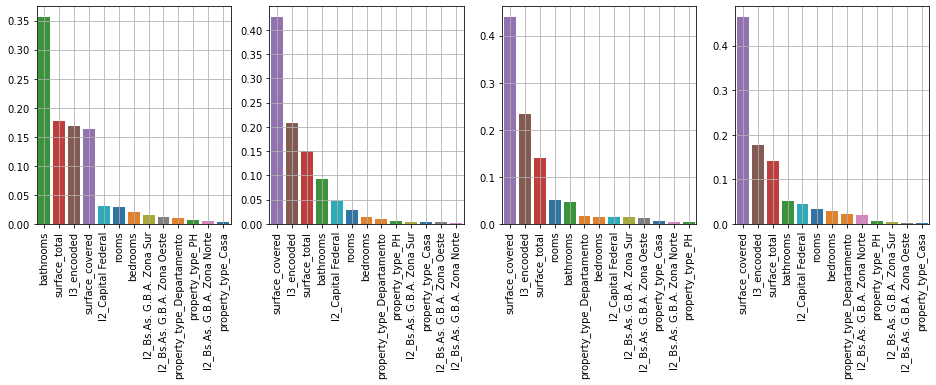

In [83]:
for i in range(1,4):
    plt.figure(figsize = (16,4))
    if i == 1:
        plt.suptitle('Importancia de las caracteristicas para algunos estimadores base aleatorios del modelo Random Forest')
    for j in range(1,5):
        plt.subplot(1,4,j)
        importancia_rfj = RandomForest_model.estimators_[np.random.randint(60)].feature_importances_
        indices_forest_rfj = np.argsort(importancia_rfj)[::-1]
        sns.barplot(columnas[indices_forest_rfj], importancia_rfj[indices_forest_rfj], palette=colors)
        plt.xticks(rotation = 90)
        plt.grid()
    plt.show();
plt.show();

Si bien la gran mayoria de los modelos base mantiene alguna o todas las caracteristicas de mayor importancia para el modelo Random Forest en los primeros lugares, eventualmente algunos modelos le dan gran importancia a otras variables secundarias como son bedrooms o rooms. Tambien se observa en la mayoria de los modelos base que poseen una caracteristica principal que es de lejos la que tiene la importancia mas alta, un comportamiento similar a lo que ocurre en el arbol de desición simple con la caracteristica bathrooms.

Este comportamiento ejemplifica la caracteristica arriba mencionada del modelo Random Forest, y es generar diversos estimadores base con alta variabilidad unos de otros y así el consenso de todos estos otorga un modelo de regresión menos sesgado que la visión de un solo árbol simple.

A partir de mi experiencia con el Dataset esperaba que las caracteristicas mas importantes para el desarrollo de los modelos fueran surface_covered y surface_total que cuantifican el tamaño de la propiedad y l3_encooded que especifica el estatus socioeconómico del barrio o comuna en el cual se encuentra la propiedad. Las 3 caracteristicas fueron de gran importancia tanto para el árbol de desición simple como para el modelo Random Forest.

Adicional a esto tenemos bathrooms, bedrooms y rooms que especifican el número de espacios útiles de la propiedad y entre los cuales bathrooms es la caracteristica que mejor se puede utilizar para predecir los precios segun lo visto en la ejecución de los modelos.

#### ¿Como es la distribución de los errores?

Lo primero que revisaremos es la curva de aprendizaje del modelo Random Forest, ya que esta nos permite examinar si el modelo cuenta con un número suficiente de instancias para su entrenamiento, que le aseguren un adecuado desempeño en la métrica seleccionada. Tambien permite visualizar si el modelo se encuentra en una región de under o overfitting.

In [ ]:
val_max = 90000
train_size, train_scores, test_scores = learning_curve(RandomForest_model, X, y, cv = 5, scoring="r2",
                                                       train_sizes = np.arange(1000, val_max+5000, 5000))
train_scores_mean = np.mean(train_scores,axis=1)
test_scores_mean = np.mean(test_scores,axis=1)
train_scores_std = np.std(train_scores,axis=1)
test_scores_std = np.std(test_scores,axis=1)

plt.figure(figsize=(8,5))
plt.fill_between(train_size, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_size, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_size, train_scores_mean, '--', color="b", label="Training score")
plt.plot(train_size, test_scores_mean, '--', color="r", label="Test score")
plt.title('Curva de aprendizaje para el modelo Random Forest')
plt.legend(loc = 4)
plt.ylabel('score R2')
plt.xlabel('número de instancias')
plt.xlim(1000,val_max)
plt.grid()
plt.show()

A partir de la curva de aprendizaje vemos que el modelo no se encuentra en una región de underfitting, pero tampoco ha llegado aun a una región de overfitting. Tambien se puede observar que el conjunto de validación tiene un aumento consistente de su score con el aumento en el número de instancias disponibles para entrenar, por lo tanto si dispusieramos de mas instancias para el entrenamiento el score mejoraría.

Ahora analizaremos la distribución del error entre los distintos tipos de propiedad y ciudad. Esto lo haremos evaluando el score para la fracción del conjunto de validación que corresponde a cada tipo en cuestión sobre el modelo Random Forest, ya que este fue el modelo con los mejores resultados obtenidos.

In [ ]:
X_test_Departamento = X_test[X_test['property_type_Departamento'] == 1]
X_test_PH = X_test[X_test['property_type_PH'] == 1]
X_test_Casa = X_test[X_test['property_type_Casa'] == 1]
X_test_Capital = X_test[X_test['l2_Capital Federal'] == 1]
X_test_Norte = X_test[X_test['l2_Bs.As. G.B.A. Zona Norte'] == 1]
X_test_Sur = X_test[X_test['l2_Bs.As. G.B.A. Zona Sur'] == 1]
X_test_Oeste = X_test[X_test['l2_Bs.As. G.B.A. Zona Oeste'] == 1]

y_test_Departamento = y_test.loc[[idx for idx in X_test_Departamento.index]]
y_test_PH = y_test.loc[[idx for idx in X_test_PH.index]]
y_test_Casa = y_test.loc[[idx for idx in X_test_Casa.index]]
y_test_Capital = y_test.loc[[idx for idx in X_test_Capital.index]]
y_test_Norte = y_test.loc[[idx for idx in X_test_Norte.index]]
y_test_Sur = y_test.loc[[idx for idx in X_test_Sur.index]]
y_test_Oeste = y_test.loc[[idx for idx in X_test_Oeste.index]]

In [ ]:
y_test_pred_Departamento = RandomForest_model.predict(X_test_Departamento)
y_test_pred_PH = RandomForest_model.predict(X_test_PH)
y_test_pred_Casa = RandomForest_model.predict(X_test_Casa)
y_test_pred_Capital = RandomForest_model.predict(X_test_Capital)
y_test_pred_Norte = RandomForest_model.predict(X_test_Norte)
y_test_pred_Sur = RandomForest_model.predict(X_test_Sur)
y_test_pred_Oeste = RandomForest_model.predict(X_test_Oeste)

r2_test_Departamento = r2_score(y_test_Departamento, y_test_pred_Departamento)
r2_test_PH = r2_score(y_test_PH, y_test_pred_PH)
r2_test_Casa = r2_score(y_test_Casa, y_test_pred_Casa)
r2_test_Capital = r2_score(y_test_Capital, y_test_pred_Capital)
r2_test_Norte = r2_score(y_test_Norte, y_test_pred_Norte)
r2_test_Sur = r2_score(y_test_Sur, y_test_pred_Sur)
r2_test_Oeste = r2_score(y_test_Oeste, y_test_pred_Oeste)

In [ ]:
Comparativo_tipos = {"Conjunto completo" : [r2_test_m6, X_test.shape[0]], 
                     "Departamento" : [r2_test_Departamento, X_test_Departamento.shape[0]], 
                     "PH" : [r2_test_PH, X_test_PH.shape[0]], 
                     "Casa" : [r2_test_Casa, X_test_Casa.shape[0]], 
                     "Capital" : [r2_test_Capital, X_test_Capital.shape[0]], 
                     "Norte" : [r2_test_Norte, X_test_Norte.shape[0]], 
                     "Sur" : [r2_test_Sur, X_test_Sur.shape[0]], 
                     "Oeste" : [r2_test_Oeste, X_test_Oeste.shape[0]]}
Comparativo_tipos = pd.DataFrame.from_dict(Comparativo_tipos, orient='index', columns=['score R2','número de propiedades'])

print('Comparativo de los score R2 para cada tipo de propiedad y ciudad en el conjunto de validación\n')
print(Comparativo_tipos)

Vemos que para los tipos de propiedad: Departamento y PH, y para la ciudad: Capital, el modelo elegido presenta muy buenos resultados, por encima del score del conjunto completo de validación.  Para el caso de la ciudad: Norte, los resultados son ligeramente inferiores al score del conjunto completo de validación.

Las dificultades para el modelo se presentan para la ciudad: Sur y Oeste y el tipo de propiedad: Casa, donde los resultados de la evaluación muy inferiores al del conjunto de validación completo, y nos deja claro que en cuestión de las variables categoricas, estas categorias son las que albergan el mayor error en el modelo.

Una posible opción para mejorar los resultados sería segmentar en dataset en grupos o categorias mas homogeneas y generar diversos modelos para cada segmento.